In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

import unittest

from gbgpu.gbgpu import GBGPU

from gbgpu.utils.constants import *

import tdi
import emcee

## Setup all the parameters and arrays to be used in these examples

In [2]:
gb = GBGPU(shift_ind=0)

In [26]:
dt = 15.0
Tobs = 4.0 * YEAR


# number of points
N = None

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-22  # amplitude
f0 = 2e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 ## not included (place holder for future?)
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude
e1 = 0.2  # eccentricity of inner binary
beta1 = 0.5  # TODO: fill in
A2 = 18.0  # third body amplitude parameter
omegabar = 0.0  # omegabar parameter
e2 = 0.3  # eccentricity of third body
P2 = 0.6  # period of third body
T2 = 0.0  # time of periapsis passage of third body

# for batching
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)
e1_in = np.full(num_bin, e1)
beta1_in = np.full(num_bin, beta1)
A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
omegabar_in = np.full(num_bin, omegabar)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

length = int(Tobs / dt)

# prepare fake data for likelihood calculation
freqs = np.fft.rfftfreq(length, dt)
data_stream_length = len(freqs)

data = [
    1e-24 * np.ones(data_stream_length, dtype=np.complex128),
    1e-24 * np.ones(data_stream_length, dtype=np.complex128),
]

noise_factor = [
    np.ones(data_stream_length, dtype=np.float64),
    np.ones(data_stream_length, dtype=np.float64),
]


## Circular Galactic Binary

In [27]:
params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

gb.run_wave(*params_circ, N=N, dt=dt, modes=np.array([2]), T=Tobs)

A = gb.A[0][0]
freqs = gb.freqs[0][0]

df = 1/Tobs

snr = np.sqrt(4 * df * np.sum(A.conj() * A/tdi.noisepsd_AE(freqs)).real)

print('snr:', snr)

snr: 538.7018711897292


In [19]:
params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

num = 100

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(
        params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
    )
et = time.perf_counter()
print("circ:", (et - st) / num, "per binary:", (et - st) / (num * num_bin))


circ: 0.005135442859999557 per binary: 0.0005135442859999557


In [20]:
plt.plot(gb.freqs[0][0], np.abs(gb.A[0][0]))


params_ecc = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(params_ecc, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=modes, T=Tobs,)
et = time.perf_counter()
print(
    "ecc ({} modes):".format(len(modes)),
    (et - st) / num,
    "per binary:",
    (et - st) / (num * num_bin),
)


for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

# zoom in on j = 3 mode
plt.plot(gb.freqs[2][0], np.abs(gb.A[2][0]))

params_circ_third = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        A2_in,
        omegabar_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    omegabar,
    e2,
    P2,
    T2,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(
        params_circ_third, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
    )
et = time.perf_counter()
print("circ / third:", (et - st) / num, "per binary:", (et - st) / (num * num_bin))


plt.plot(gb.freqs[0][0], np.abs(gb.A[0][0]))

params_full = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
        A2_in,
        omegabar_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    A2,
    omegabar,
    e2,
    P2,
    T2,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(params_full, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=modes, T=Tobs,)
et = time.perf_counter()
print(
    "ecc/third ({} modes):".format(len(modes)),
    (et - st) / num,
    "per binary:",
    (et - st) / (num * num_bin),
)


for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

125829120.0

In [9]:
df = 1/(Tobs) 
fmax = 1e-2
noise_freqs = np.arange(0.0, fmax, df)

AE_noise = tdi.noisepsd_AE(noise_freqs)

noise_factor = [1/np.sqrt(AE_noise) * np.sqrt(df), 1/np.sqrt(AE_noise) * np.sqrt(df)]

/Users/michaelkatz/.local/lib/python3.8/site-packages/tdi.py:647: RuntimeWarning: divide by zero encountered in true_divide
  Sa_a = LP.Sa_a[model] *(1.0 +(0.4e-3/frq)**2)*(1.0+(frq/8e-3)**4)
/Users/michaelkatz/.local/lib/python3.8/site-packages/tdi.py:649: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a*(2.*np.pi*frq)**(-4.)
/Users/michaelkatz/.local/lib/python3.8/site-packages/tdi.py:651: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d*(2.0*np.pi*frq/LC.clight)**2
/Users/michaelkatz/.local/lib/python3.8/site-packages/tdi.py:656: RuntimeWarning: divide by zero encountered in true_divide
  Soms_d = LP.Soms_d[model] * (1. + (2.e-3/f)**4)
/Users/michaelkatz/.local/lib/python3.8/site-packages/tdi.py:658: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d*(2.0*np.pi*frq/LC.clight)**2


In [28]:
%matplotlib qt
plt.loglog(noise_freqs, AE_noise)
plt.plot(gb.freqs[0][0], 2 * 1/Tobs * np.abs(gb.A[0][0])**2)
#plt.xlim(0.0019989808400472007, 0.002001007397969564)

# inject eccentric signal

params_ecc = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj, E_inj]  # right summation rule

# try to extract with ecc

like = gb.get_ll(
    params_ecc, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

print('ecc template log likelihood:', like)

# try to extract with circular

params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

like = gb.get_ll(
    params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

print('circ template log likelihood:', like)

# inject circular with eccentric third body

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    omegabar,
    e2, 
    P2, 
    T2,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj, E_inj]  # right summation rule

# try to extract with circular third body

like = gb.get_ll(
    params_circ_third, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

A_third = gb.A[0][0].copy()
freqs_third = gb.freqs[0][0].copy()

print('circular third body template likelihood:', like)

# try to extract with circular

params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

like = gb.get_ll(
    params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

A_circ = gb.A[0][0].copy()

freqs_circ = gb.freqs[0][0].copy()

print('circ template likelihood:', like)

## Fisher

num_bin = 100
amp = 1e-19
f0 = 2e-3
fdot = 1e-14
fddot = 0.0
phi0 = 0.1
iota = 0.2
psi = 0.3
lam = 0.4
beta_sky = 0.5
A2 = 19.5
omegabar = 0.0
e2 = 0.3
P2 = 0.6
T2 = 0.0

amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)
A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
omegabar_in = np.full(num_bin, omegabar)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

N = int(1024)

Tobs = 4.0 * YEAR
dt = 15.0

waveform_kwargs = dict(N=N, dt=dt, T=Tobs)

# ln (amp), f0 in ms, ln (fdot)
transform_fn = {
    0: np.exp,
    1: (lambda x: x * 1e-3),
    2: np.exp,
}

injection_params = np.array(
    [
        np.log(amp),
        f0 * 1e3,
        fdot,
        fddot,
        phi0,
        iota,
        psi,
        lam,
        beta_sky,
        A2,
        omegabar,
        e2,
        P2,
        T2,
    ]
)

fish_params = np.array(
    [
        np.log(amp_in),
        f0_in * 1e3,
        np.log(fdot_in),
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        A2_in,
        omegabar_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

inds_test = np.delete(np.arange(len(fish_params)), 3)
fish = gb.fisher(
    fish_params, inds=inds_test, parameter_transforms=transform_fn, **waveform_kwargs
)

fish

fish[0]

fish[0].diagonal()

cov = np.linalg.pinv(fish[0])

np.sqrt(cov.diagonal()) # standard deviation

## emcee example

In [4]:
from scipy.stats import uniform

def uniform_dist(min, max):
    if min > max:
        temp = min
        min = max
        max = temp

    mean = (max + min) / 2.0
    sig = max - min
    dist = uniform(min, sig)
    return dist

In [6]:
df = 1/(Tobs) # not exactly right
fmax = 1e-2
noise_freqs = np.arange(0.0, fmax, df)

AE_noise = tdi.noisepsd_AE(noise_freqs)

noise_factor = [1/np.sqrt(AE_noise) * np.sqrt(df), 1/np.sqrt(AE_noise) * np.sqrt(df)]

injection_params = np.array([
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    omegabar,
    e2, 
    P2, 
    T2,
])
A_inj, E_inj = gb.inject_signal(
    *injection_params,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj, E_inj]

In [7]:
priors = [
    uniform_dist(amp * 0.95, amp * 1.05),
    uniform_dist(f0 * 0.95, f0 * 1.05),
    uniform_dist(fdot * 0.95, fdot * 1.05),
    uniform_dist(fddot * 0.95, fddot * 1.05),
    uniform_dist(0.0, 2 * np.pi),
    uniform_dist(0.0, np.pi),
    uniform_dist(0.0, np.pi),
    uniform_dist(0.0, 2 * np.pi),
    uniform_dist(-np.pi/2, np.pi/2.),
    uniform_dist(A2 * 0.95, A2 * 1.05),
    uniform_dist(0.0, 0.5),
    uniform_dist(e2 * 0.95, e2 * 1.05),
    uniform_dist(P2 * 0.95, P2 * 1.05),
    uniform_dist(0.0, 1.0),
]

In [41]:
class Likelihood:
    def __init__(self, lnlike, priors, data, noise_factor, N, dt, modes, Tobs):
        self.priors = priors
        self.lnlike = lnlike
        self.data = data
        self.noise_factor = noise_factor
        self.N, self.dt, self.modes, self.Tobs = N, dt, modes, Tobs
        
    def __call__(self, x):
        prior_vals = np.zeros((x.shape[0]))
        for prior_i, x_i in zip(self.priors, x.T):
            temp = prior_i.logpdf(x_i)

            prior_vals[np.isinf(temp)] += -np.inf
            
        inds_eval = np.atleast_1d(np.squeeze(np.where(np.isinf(prior_vals) != True)))

        loglike_vals = np.full(x.shape[0], -np.inf)

        if len(inds_eval) == 0:
            return np.array([-loglike_vals, prior_vals]).T

        temp = self.lnlike.get_ll(
            x[inds_eval].T, self.data, self.noise_factor, N=self.N, dt=self.dt, modes=self.modes, T=self.Tobs,
        )

        loglike_vals[inds_eval] = temp

        return np.array([loglike_vals, prior_vals]).T

In [42]:
like = Likelihood(gb, priors, data, noise_factor, N, dt, np.array([2]), Tobs)

In [43]:
ndim = len(injection_params)
nwalkers = 100

test_x = np.tile(injection_params, (nwalkers, 1))

print(like(test_x))

[[1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189894e-12 0.0000000e+00]
 [1.8189

/Users/michaelkatz/anaconda3/envs/gbgpu_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1802: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [44]:
factor = 1e-8
start_points = test_x * (1 + factor * np.random.randn(nwalkers, ndim))
inds = np.where(start_points == 0.0)

start_points[inds] = np.abs(factor * np.random.randn(nwalkers, ndim))[inds]
print(like(start_points))

[[1.20576345e+00 0.00000000e+00]
 [4.41114742e-02 0.00000000e+00]
 [3.46028856e-01 0.00000000e+00]
 [5.78320337e-02 0.00000000e+00]
 [5.42863689e-04 0.00000000e+00]
 [1.88296289e-01 0.00000000e+00]
 [3.07323620e-02 0.00000000e+00]
 [1.56069484e-01 0.00000000e+00]
 [9.77295802e-01 0.00000000e+00]
 [5.61122163e-01 0.00000000e+00]
 [1.43230359e-03 0.00000000e+00]
 [7.31024440e-04 0.00000000e+00]
 [1.83904699e-03 0.00000000e+00]
 [1.02603808e+00 0.00000000e+00]
 [1.89859347e-01 0.00000000e+00]
 [2.85021451e-01 0.00000000e+00]
 [1.12043981e-01 0.00000000e+00]
 [2.89340739e-02 0.00000000e+00]
 [3.67557806e-01 0.00000000e+00]
 [1.98508929e+00 0.00000000e+00]
 [2.02065406e-04 0.00000000e+00]
 [2.10635282e-02 0.00000000e+00]
 [8.17147678e-02 0.00000000e+00]
 [2.01302283e+00 0.00000000e+00]
 [3.13035271e+00 0.00000000e+00]
 [6.32620091e-04 0.00000000e+00]
 [1.56420033e-01 0.00000000e+00]
 [9.26318956e-02 0.00000000e+00]
 [6.11070964e-02 0.00000000e+00]
 [2.60250785e-01 0.00000000e+00]
 [2.763578

In [45]:
sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            like,
            vectorize=True,
        )

In [46]:
nsteps = 1000
sampler.reset()
sampler.run_mcmc(start_points, nsteps, progress=True)

State([[2.00336638e-19 2.00003076e-03 9.99885714e-15 ... 2.99794719e-01
  6.00623549e-01 5.01645699e-04]
 [2.07302877e-19 1.99998793e-03 1.01581279e-14 ... 2.93459059e-01
  5.85017100e-01 2.00989623e-02]
 [2.07619860e-19 1.99998782e-03 1.01588261e-14 ... 3.09569284e-01
  5.90305144e-01 5.42410362e-02]
 ...
 [2.08854015e-19 1.99998722e-03 1.01673430e-14 ... 3.02670688e-01
  5.93777233e-01 6.79006849e-02]
 [2.08395169e-19 1.99998762e-03 1.01617529e-14 ... 3.05976487e-01
  5.92138099e-01 7.90615625e-02]
 [2.09736825e-19 1.99998767e-03 1.01572512e-14 ... 2.86448123e-01
  5.82297055e-01 1.12165539e-02]], log_prob=[12920.33422364 17064.91725977 17094.35101607 17063.84852572
 17088.90850503 17059.2925746  17074.80006691 17093.31759835
 16046.46549321 16043.29327257 17091.6524032  17071.58700815
 17083.68950523 17077.93184354 16045.59390933 17076.06537462
 17064.1313107  16030.70296255 17062.37939071 17089.68754652
 17079.51740307 17085.5862116  17070.44181955 17119.5542966
 17081.97551227 160

In [47]:
samples = sampler.get_chain(flat=True)

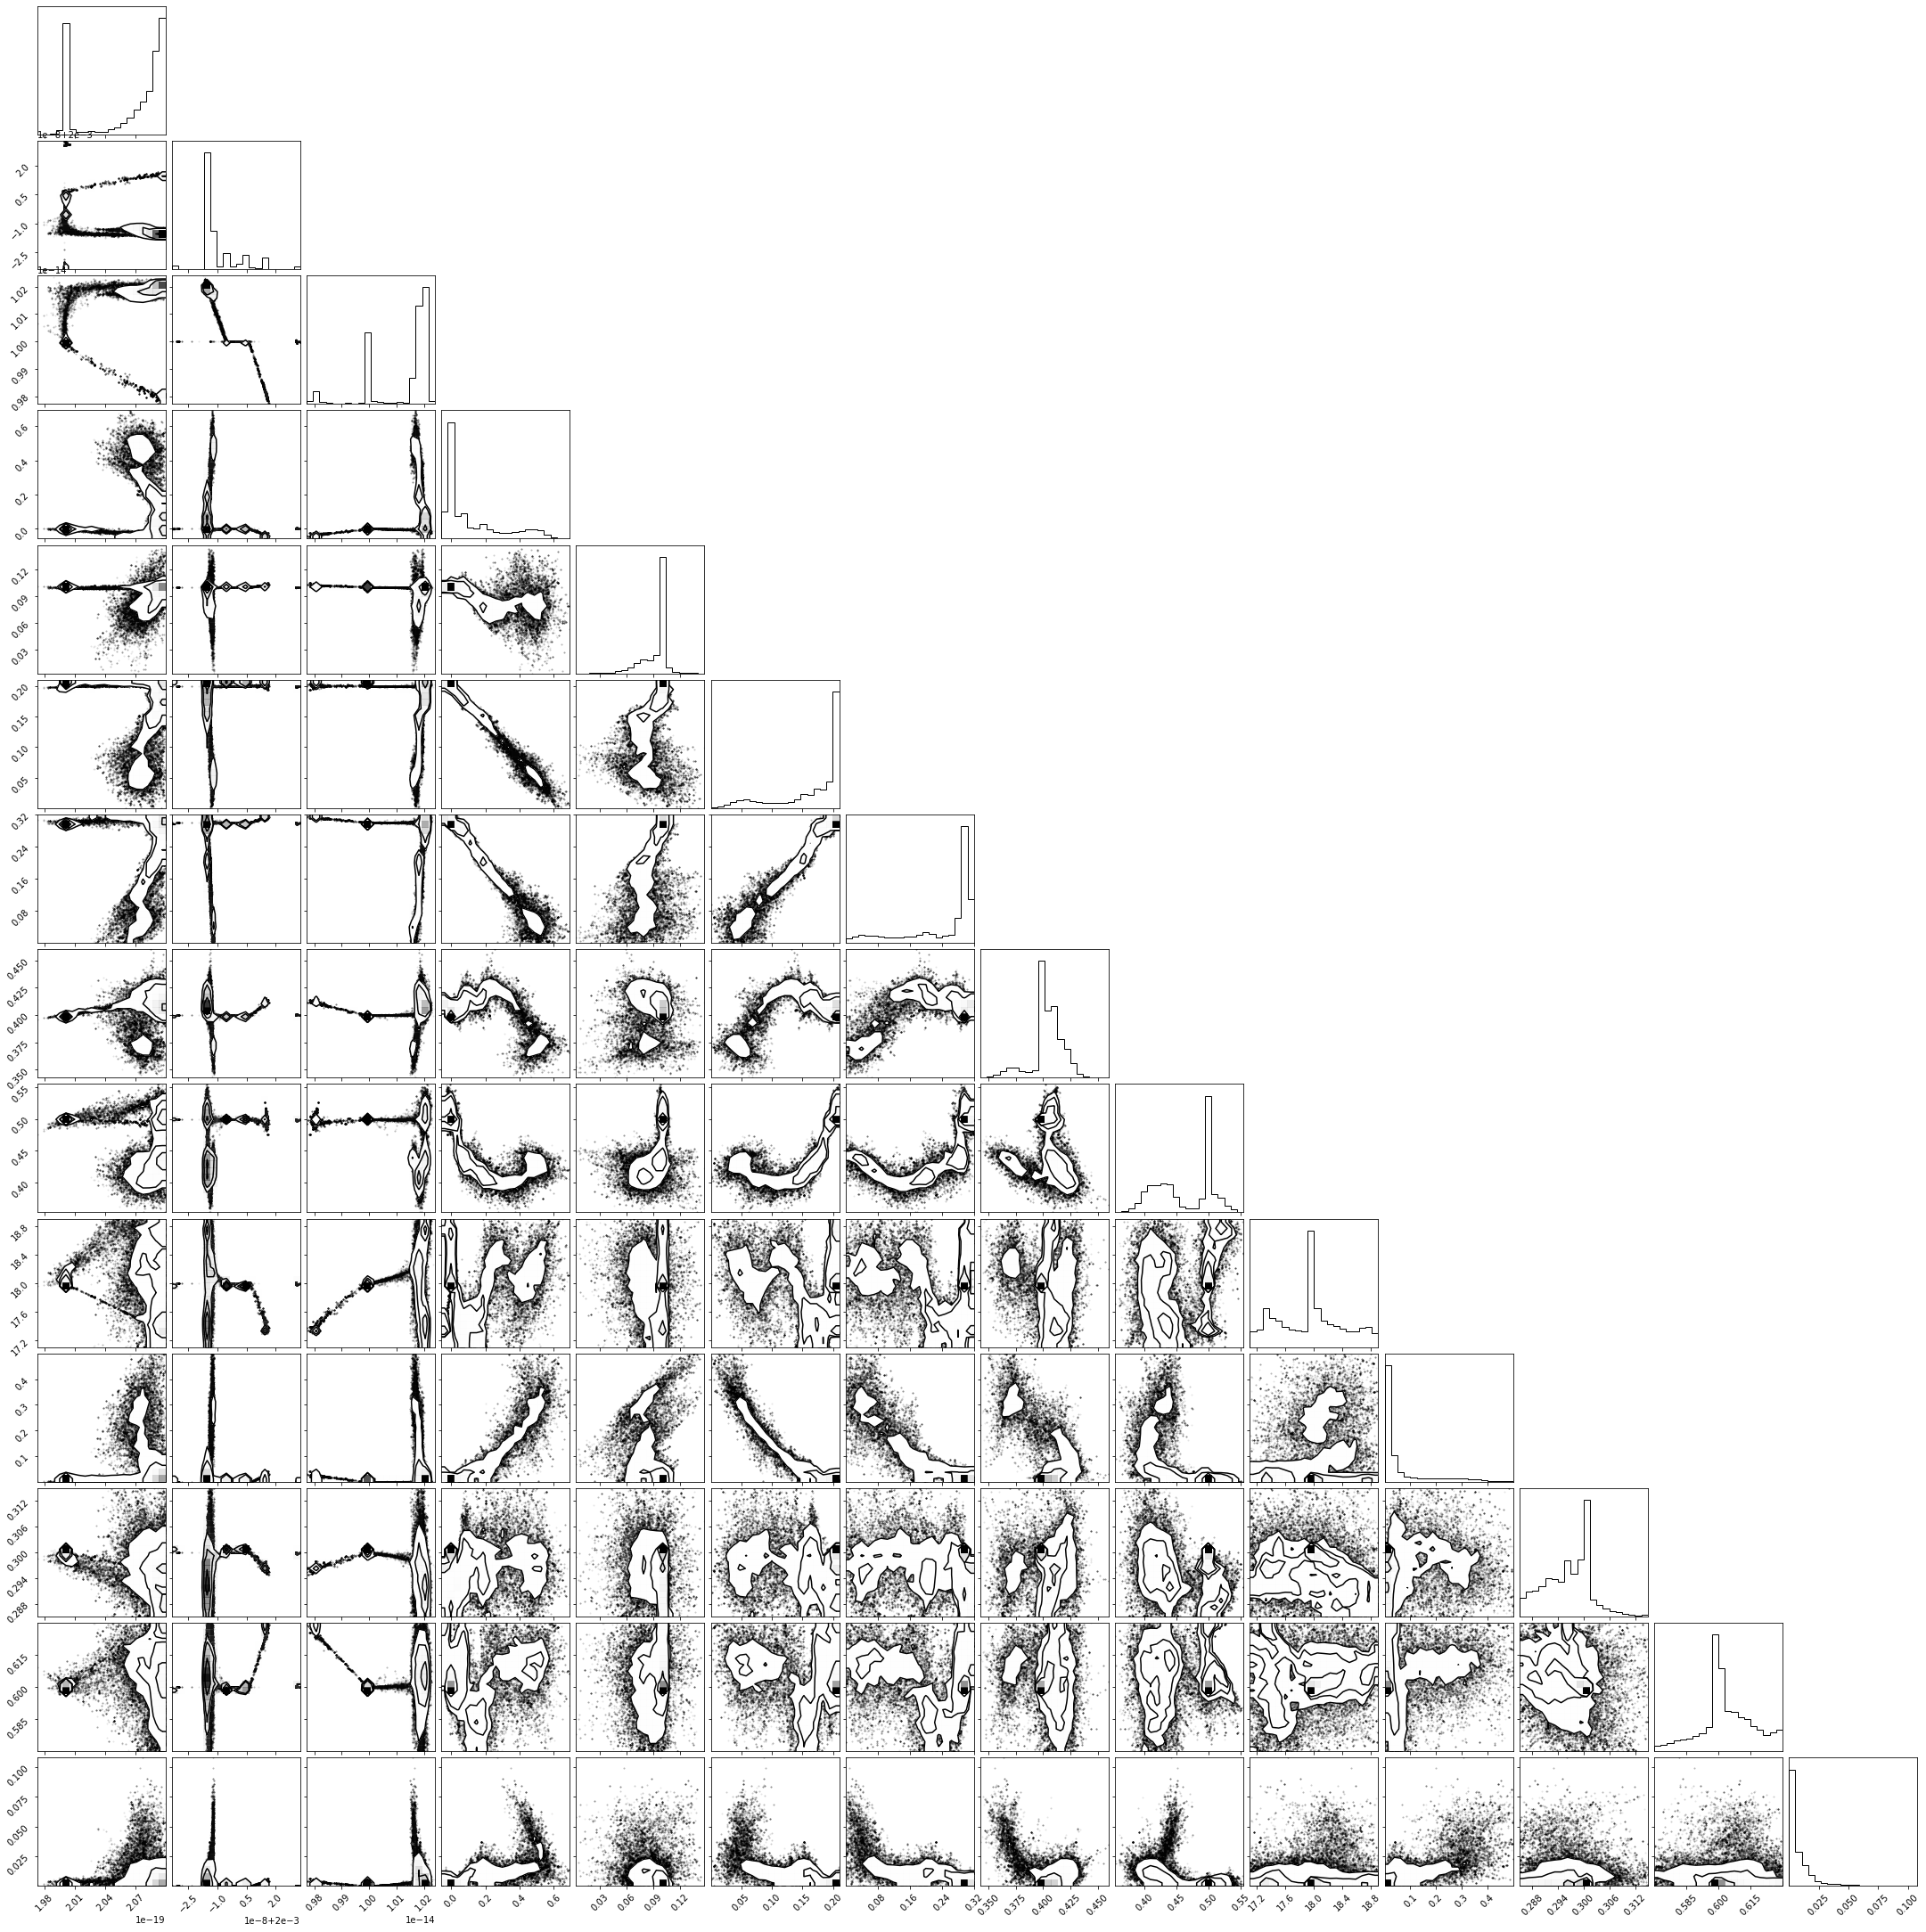

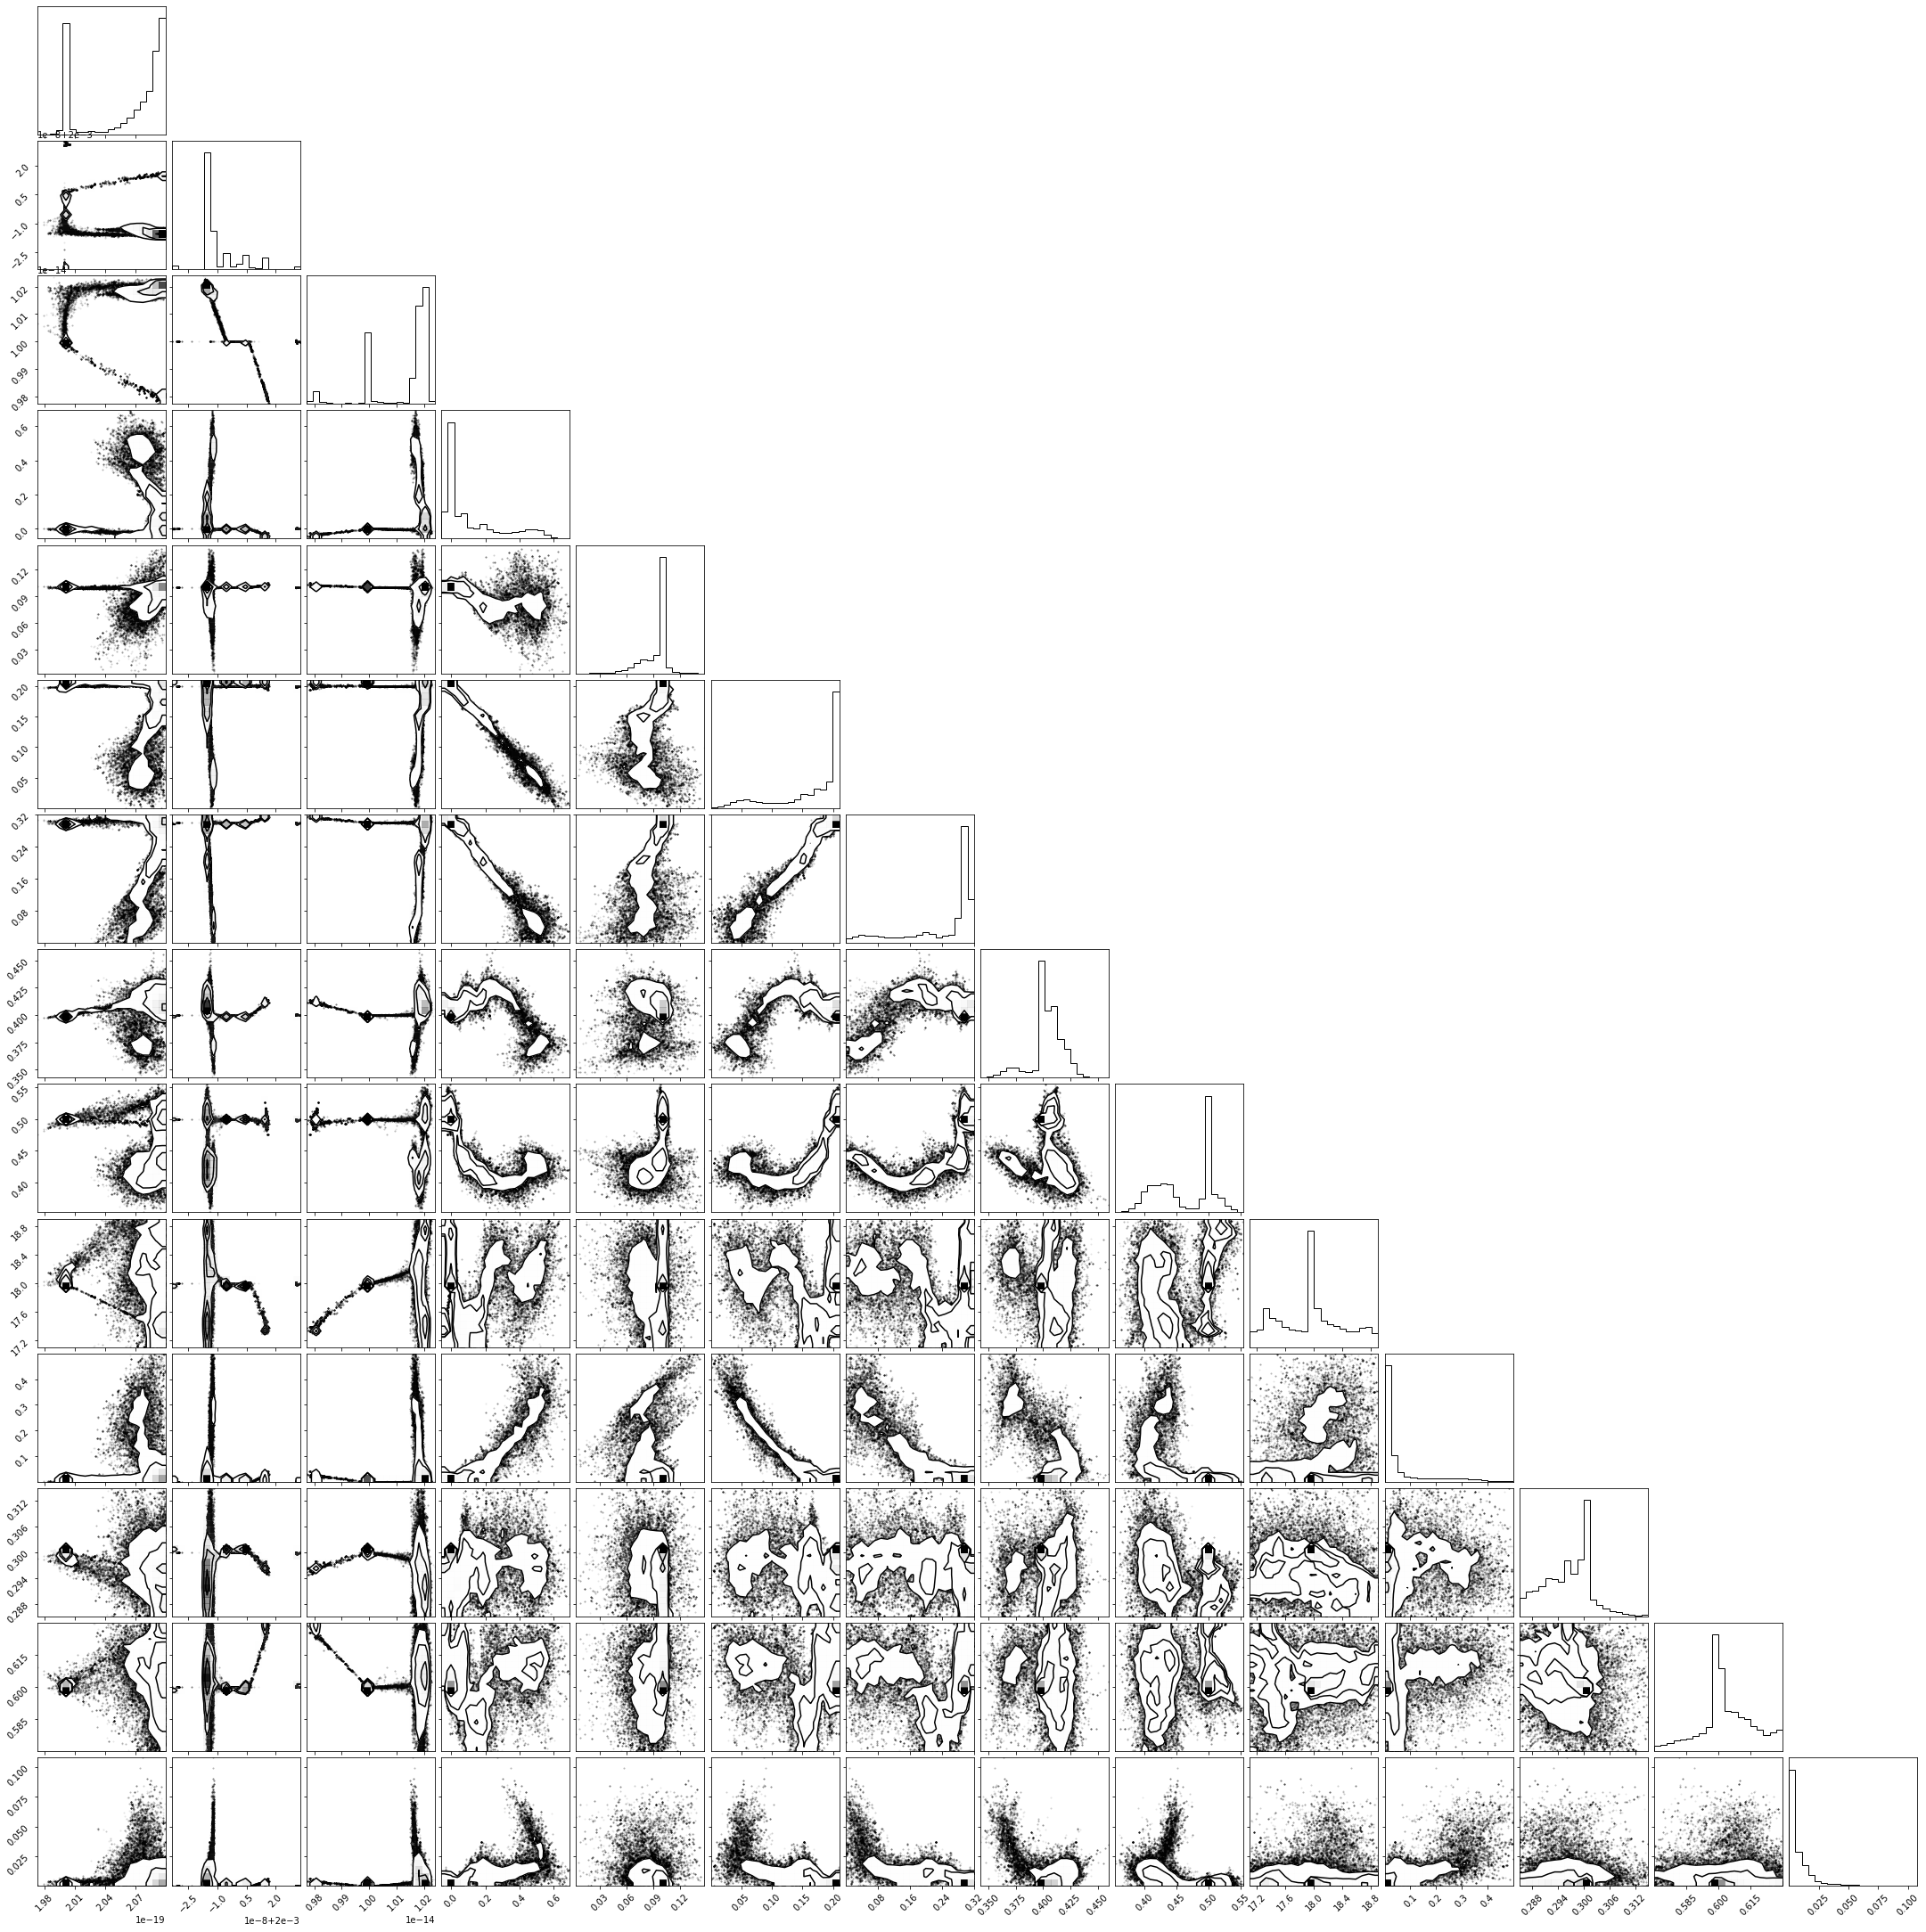

In [48]:
import corner
corner.corner(samples)